plot facebook data in a 2D Histogramm

In [1]:
# takes around 3mins repending on number of points
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import utm

# read
df = pd.read_csv("pop_ger.csv", sep = ",", names = ["y","x","weight"], dtype = np.float16, skiprows = 1)

# carefull this is about square
LONMIN = 50.822654
LATMIN = 11.411137

LONMAX = 51.669633
LATMAX = 13.226496

print("selecting the relevant rows...")
# select rows that are inside of the bounding box
df = df[(df.x >= LATMIN) & (df.x <= LATMAX)]
df = df[(df.y >= LONMIN) & (df.y <= LONMAX)]

print("converting to numpy...")
# convert to numpy
x = df["x"].tolist()
y = df["y"].tolist()
weight = df["weight"].tolist()

print(len(x))
print(len(y))

selecting the relevant rows...
converting to numpy...
1269076
1269076


plotting...


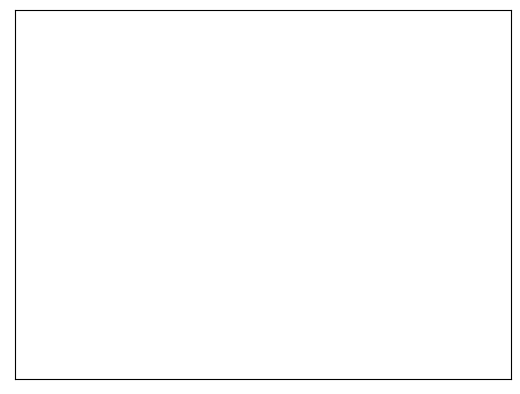

In [7]:
BINS = 100
BLUR = 1

print("plotting...")

fig, ax = plt.subplots()
data = np.histogram2d(x, y, weights = weight, bins=BINS)[0]
data = gaussian_filter(data, sigma=BLUR)
plt.pcolormesh(data.T, cmap='inferno', shading='gouraud')
ax.set_xticks([])
ax.set_yticks([])
fig.canvas.draw()

Relating everything back to how good each place is connected

Metrics:

- Stop Density
- "Mobility Score"

12.570972222232278 51.25180555559656
129 137
12.564027777787828 51.25013888892989
73 104
12.562638888898938 51.24680555559655
61 38
12.570138888898944 51.253750000041
122 176
12.56930555556561 51.25069444448544
116 115
12.568750000010054 51.25430555559656
111 187
12.574305555565614 51.25180555559656
156 137
12.571250000010057 51.25347222226322
131 170
12.565694444454495 51.25513888892989
86 203
12.56652777778783 51.25486111115211
93 198
12.574027777787837 51.25013888892989
154 104
12.571527777787834 51.253750000041
134 176
12.567083333343389 51.24847222226322
98 71
12.567361111121164 51.24930555559655
100 88
12.56930555556561 51.24986111115211
116 99
12.566805555565608 51.24986111115211
95 99
12.571527777787834 51.25069444448544
134 115
12.570972222232278 51.25513888892989
129 203
12.569861111121169 51.253194444485445
120 165
12.56652777778783 51.254583333374335
93 192
12.56236111112116 51.24652777781877
59 33
12.562916666676715 51.24847222226322
64 71
12.562083333343384 51.24819444448

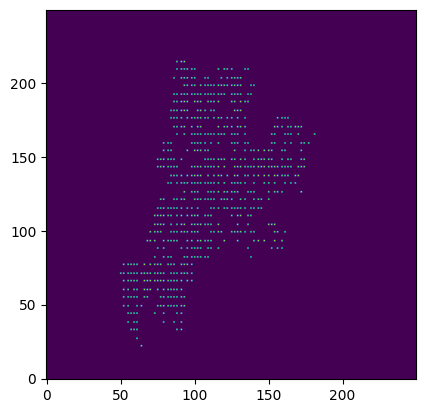

In [10]:

import math as m
import matplotlib.pyplot as plt


GRIDSIZE = 250

POPULATIONGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)]


l = []
def getindices(lat, lon):

    print(lat, lon)

    xind = m.floor(((lat-LATMIN) / (LATMAX - LATMIN)) * GRIDSIZE) # data normalisation to be in the range of 0 - 99
    yind = m.floor(((lon-LONMIN) / (LONMAX - LONMIN)) * GRIDSIZE)


    print(xind, yind)

    return [xind,yind]

for x1, y1, w1 in zip(x,y, weight):
    xind, yind = getindices(x1,y1)
    POPULATIONGRID[yind][xind] += w1

# sanity check

TOTALPOP = np.sum(POPULATIONGRID)
print("Number of Inhabitants: ", TOTALPOP)

plt.imshow(POPULATIONGRID, interpolation = None, origin = "lower")
plt.show()



Read in Neighbours and put them on the same grid

In [4]:
# calculate some stats
import math as m
import haversine as hs 

diagonal = hs.haversine((LATMAX, LONMAX), (LATMIN, LONMIN))
side = diagonal / m.sqrt(2)

# Maßstab berechnen
onepxlength = side / GRIDSIZE # length of one pixel in grid in KM

print("One Pixel in KM:", onepxlength)
print("Square side Length in KM: ", side)

One Pixel in KM: 0.010412066777060618
Square side Length in KM:  2.6030166942651545


In [5]:
import json
from utils import load_stops_as_dict
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve
import numpy as np

# load all stops
all_stops = load_stops_as_dict()


f = open("lvb_auswertung/neighbours_1.json")
nb = json.load(f)

STOPSGRID = [[0 for i in range(GRIDSIZE)] for j in range (GRIDSIZE)] # create grid thats 0-99

for key_stop, nb_list in nb.items():


    w = len(nb_list)
    lat, lon = all_stops[key_stop]

    # convert directly to grid indices 
    xind, yind = getindices(lon, lat)


    # not all stops are inside of the bounding box created earlier
    if (0 <= yind < GRIDSIZE) and (0 <= xind < GRIDSIZE):
        STOPSGRID[yind][xind] += 1

        # TODO use weighted stops
        # STOPSGRID[yind][xind] += 1

# blur the stops because they are "reachable" in a circle around them
#BLURREDSTOPSGRID = gaussian_filter(np.array(STOPSGRID), sigma=0)


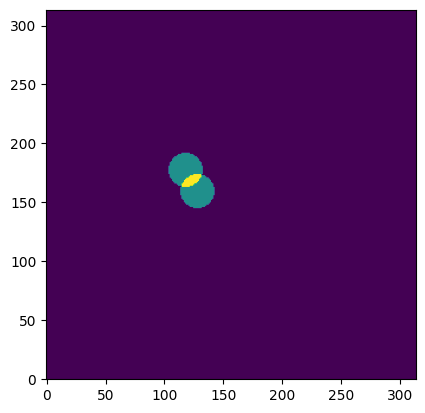

In [6]:
def convolve_stopgrid(r_orig = 0.15):

    #assert r_orig <= 1

    # TODO this has to be adapted to the actual selection size. Otherwise the stop radius is too wide
    cx = 30.
    cy = 30.
    r = r_orig/onepxlength

    fx = np.arange(0, 4.5 * r) 
    fy = np.arange(0, 4.5 * r)
    farr = np.zeros((fy.size, fx.size))

    mask = (fx[np.newaxis,:]-cx)**2 + (fy[:,np.newaxis]-cy)**2 < r**2
    farr[mask] = 1.

    kernel = farr
    # CONVOLVEDSTOPSGRID = convolve2d(STOPSGRID, kernel)
    CONVOLVEDSTOPSGRID = fftconvolve(STOPSGRID, kernel) # faster

    return CONVOLVEDSTOPSGRID

if __name__ == "__main__":
    CONVOLVEDSTOPSGRID = convolve_stopgrid()
    plt.imshow(CONVOLVEDSTOPSGRID, interpolation = None, origin = "lower")
    plt.show()

Analyzing both grids
- how many people live withing x meters of a bus stop
- how many people 

In [7]:

numstops = 2






100%|██████████| 20/20 [00:00<00:00, 22.96it/s]


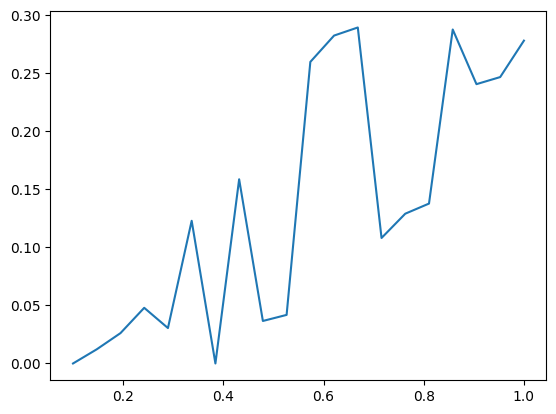

In [8]:
# generate function people(distance)

SAMPLES = 20
START_RADIUS = 0.1 # in KM
STOP_RADIUS = 1 # in KM

radius_list = np.linspace(START_RADIUS, STOP_RADIUS, SAMPLES)

all_x = []
all_y = []

for i in tqdm(radius_list):
    all_y.append(analyze_grids(convolve_stopgrid(i)))
    all_x.append(i)

plt.plot(all_x, all_y)
plt.show()
    
    


